# Setup Variables

In [1]:
REPO_PATH = '/home/ah19/runtime-monitoring'
DATASET = 'GTSRB'
PREFIX = 'BestRegularization'
FILENAME_POSTFIX = f"{DATASET}_{PREFIX}"
SEED = 42

GPU_NAME = 'cuda:0'

model_setup = {'dropout': 0.2, 'first_layer_norm': False}
model_config = {
    'batch_size': 32,
    'lr': 0.001,
    'epochs': 15,
    "patience": 3,
    "L2": 0.0,
    "L1": 0.0
}

# Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.backends import cudnn
from torchinfo import summary

In [3]:
import sys
sys.path.append(REPO_PATH + '/utilities')
sys.path.append(f'{REPO_PATH}/{DATASET}/trainingModels')

In [4]:
from utils import *
from plotFunctions import *
from pathManager import fetchPaths
from GTSRB_CNN import GTSRB_CNN

model_ = GTSRB_CNN

# GPU Device & Seed

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [6]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

# Paths

In [7]:
base = Path(REPO_PATH)
paths = fetchPaths(base, DATASET)

path = paths[DATASET.lower()]
path_dataset = paths['dataset']
path_trainingModels = paths['trainingModels']
path_lastHiddenLayer = paths['lastHiddenLayer']
path_lastHiddenLayer_raw = paths['lastHiddenLayer_raw']
path_savedModels = paths['savedModels']

# save model and logs to dedicated directory
if path_savedModels.is_dir(): print('! IMPORTANT: Model already exist !')
path_savedModels = path_savedModels / FILENAME_POSTFIX
path_savedModels.mkdir(exist_ok=True)

path_lastHiddenLayer_raw = path_lastHiddenLayer_raw / FILENAME_POSTFIX
path_lastHiddenLayer_raw.mkdir(exist_ok=True)

path, path_savedModels

! IMPORTANT: Model already exist !


(PosixPath('/home/ah19/runtime-monitoring/GTSRB'),
 PosixPath('/home/ah19/runtime-monitoring/GTSRB/savedModels/GTSRB_BestRegularization'))

# Load / Split / DataLoader

In [8]:
feature_names = get_labels(DATASET)

tf_train = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32)),
    T.Normalize((0.3359, 0.3110, 0.3224), (0.3359, 0.3110, 0.3224))
])


tf_test = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32)),
    T.Normalize((0.3359, 0.3110, 0.3224), (0.3359, 0.3110, 0.3224))
])

train_data = get_dataset(DATASET, path_dataset, train=True, transform=tf_train)
test_data = get_dataset(DATASET, path_dataset, train=False, transform=tf_test)

len(train_data), len(test_data)

(77400, 12630)

In [9]:
trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


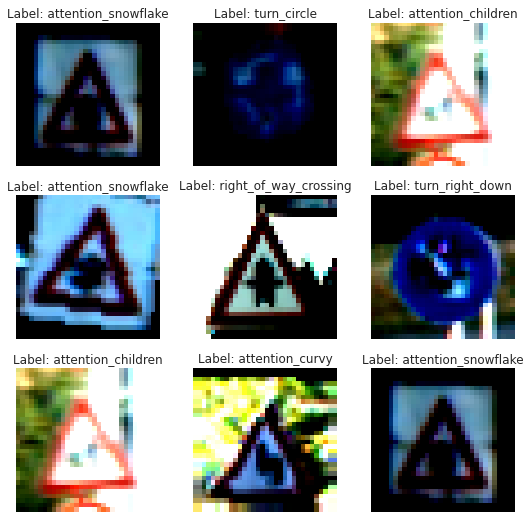

In [10]:
show_images_loader(trainloader, feature_names=feature_names)

# Model

In [11]:
# skip classes
skip_classes = None
map_classes = None

In [12]:
model = model_(**model_setup)
model.to(device)

nn.DataParallel(model, device_ids=[0])
cudnn.benchmark = True

summary(model, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
GTSRB_CNN                                --                        --
├─Conv2d: 1-1                            [1, 128, 28, 28]          9,600
├─BatchNorm2d: 1-2                       [1, 128, 28, 28]          256
├─ReLU: 1-3                              [1, 128, 28, 28]          --
├─MaxPool2d: 1-4                         [1, 128, 14, 14]          --
├─Conv2d: 1-5                            [1, 128, 12, 12]          147,456
├─BatchNorm2d: 1-6                       [1, 128, 12, 12]          256
├─ReLU: 1-7                              [1, 128, 12, 12]          --
├─MaxPool2d: 1-8                         [1, 128, 6, 6]            --
├─Conv2d: 1-9                            [1, 64, 5, 5]             32,768
├─BatchNorm2d: 1-10                      [1, 64, 5, 5]             128
├─ReLU: 1-11                             [1, 64, 5, 5]             --
├─Conv2d: 1-12                           [1, 64, 4, 4]             16,

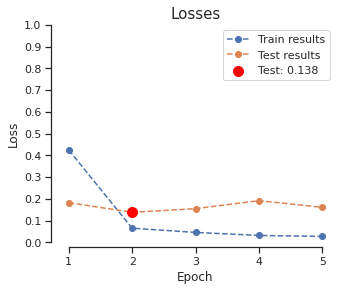

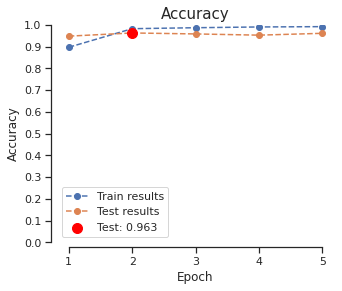

In [13]:
# cost function
loss_function = nn.CrossEntropyLoss()

# optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=model_config['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr=model_config['lr'])

# LR Scheduler

# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=2, T_mult=1, eta_min=1e-4, verbose=True)


# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=model_config['epochs'], verbose=True)

# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=model_config['patience'], mode='max',
#     factor=1e-1, min_lr=1e-4, verbose=True)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=10 )

# lr_scheduler = None

# run_training_testing arguments
kwargs = {
    'model': model,
    'loss_function': loss_function,
    'optimizer': optimizer,
    'lr_scheduler': lr_scheduler,
    'map_classes': map_classes,
    'skip_classes': skip_classes,
    'device': device,
    'model_path': path_savedModels / f"{DATASET}_{PREFIX}.pth.tar",
    'trainloader': trainloader,
    'testloader': testloader,
    'config': model_config
}

# train
train_losses, test_losses, train_accs, test_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = run_training_testing(**kwargs)

# Exporting last hidden layer data

In [14]:
# create empty model
model = model_(**model_setup)
model.to(device)

# load model
# model_file_name = path_savedModels / 'MNIST_Adam256-acc-0.988-loss-0.037.pth.tar'
model_file_name = best_model_name
load_checkpoint(model, model_file_name)

model_file_name

PosixPath('/home/ah19/runtime-monitoring/GTSRB/savedModels/GTSRB_BestRegularization/GTSRB_BestRegularization-acc-0.963-loss-0.138.pth.tar')

In [15]:
# export last hidden layer for each data loader

for loader, stage in [
    (trainloader, 'train'),
    (testloader, 'test'),
]:
    export_last_hidden_layer(loader, model, device, model.last_hidden_neurons,
                          map_classes, path_lastHiddenLayer_raw, FILENAME_POSTFIX, stage)

# Confusion Matrix

In [16]:
save_confusion_matrix(confusion_matrix_test, path_savedModels, FILENAME_POSTFIX, 'test')

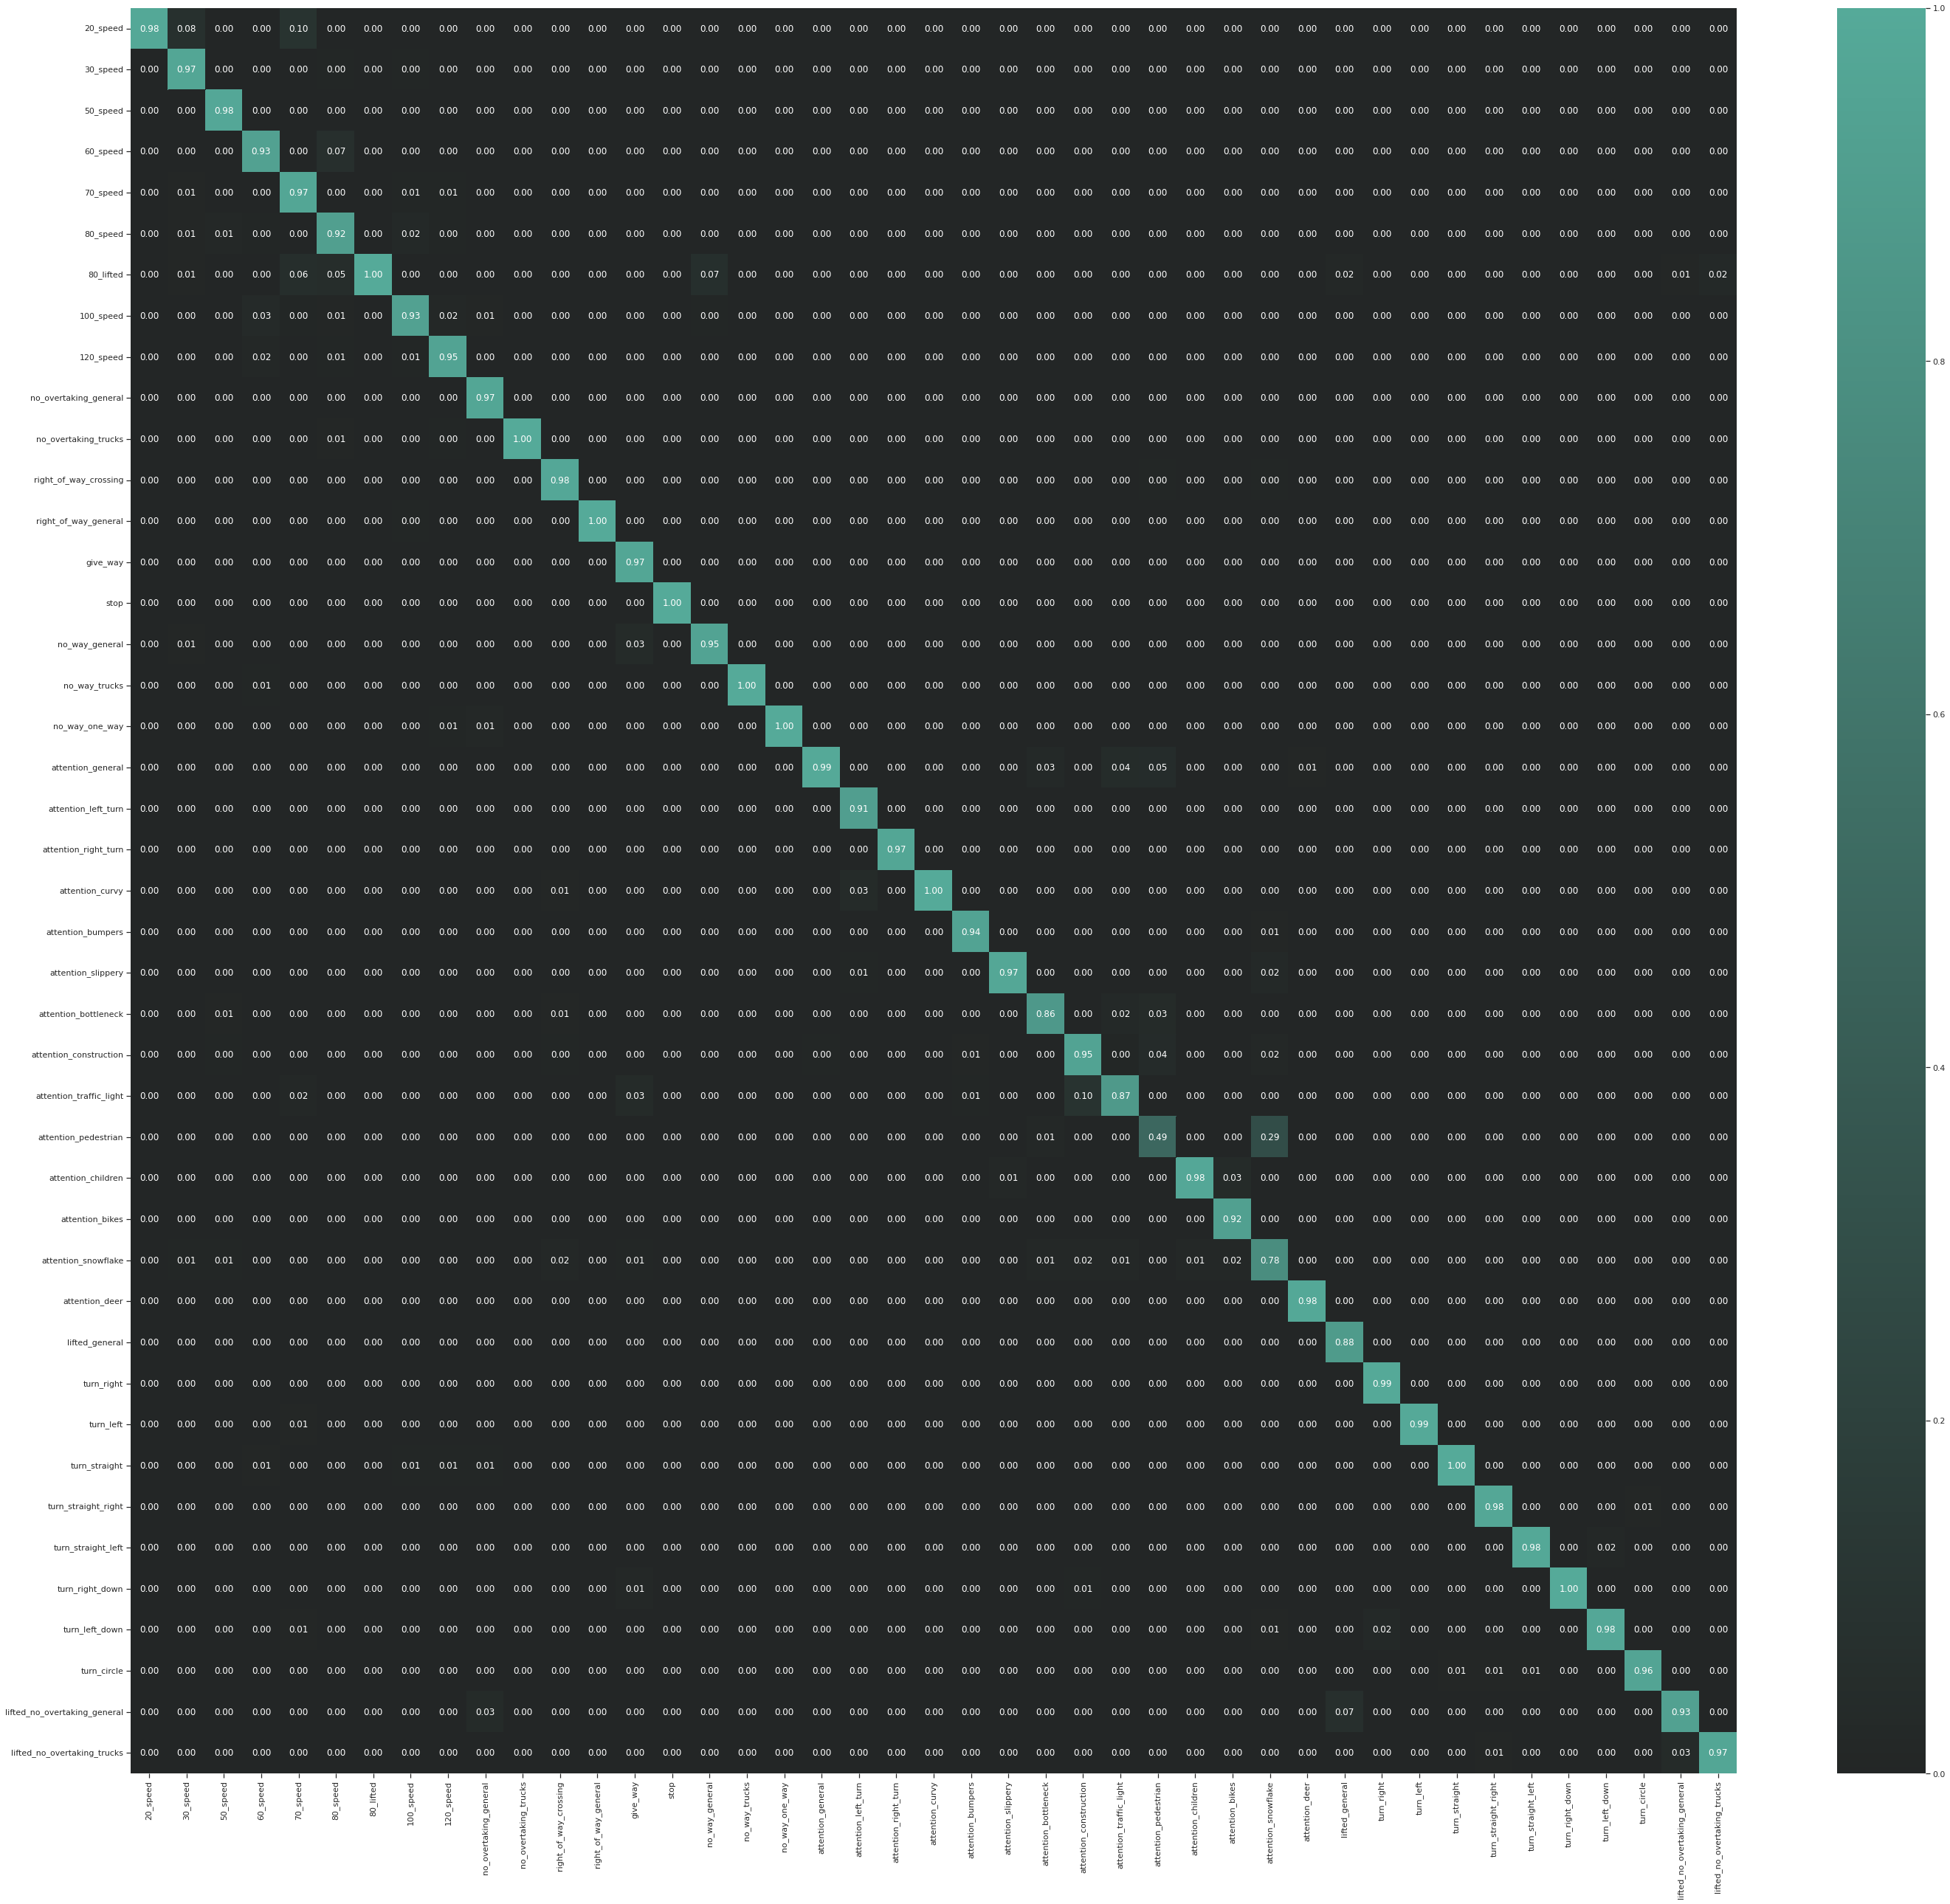

In [18]:
confusion_matrix_test_norm = normalize_confusion_matrix(confusion_matrix_test)
fig, ax = plot_confusion_matrix( confusion_matrix_test_norm, feature_names, None, fmt='.2f')